# Proyecto Redes Neuronales: Perceptrón Multicapa

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo de Perceptrón Multicapa (MLP) para clasificación de texto según el enunciado del proyecto.  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Componentes implementados:
1. Configuración de Parámetros Globales
2. Carga y Preprocesamiento de Datos
3. Tokenización y Creación del Vocabulario
4. Construcción del Modelo MLP
5. Entrenamiento con Early Stopping
6. Evaluación del Modelo
7. Guardado de Resultados y Modelos
8. Visualización de Resultados
9. Historial de Experimentos

## 0. Configuración de Parámetros Globales

Esta sección permite modificar fácilmente todos los parámetros del modelo para experimentar.

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====
# Esta sección centraliza todos los parámetros del modelo para facilitar experimentación

# Configuración general del experimento
EXPERIMENT_NAME = "MLP_BoW"
MODEL_TYPE = "MLP_BoW"  # Perceptrón Multi-Capa con BoW/TF-IDF
RANDOM_SEED = 42

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = "models"
OUTPUT_DIR = "output"

# Configuración del dataset 
TEXT_COLUMN = "review_body"  # Columna con el texto del cuerpo de la reseña
TITLE_COLUMN = "review_title"  # Columna con el título de la reseña
TARGET_COLUMN = "stars"  # Columna con las etiquetas (1-5 estrellas)
LANGUAGE_COLUMN = "language"  # Columna con el idioma
FILTER_LANGUAGE = "en"  # Filtrar por idioma específico. Opciones: None, "en", "es", "de", "fr", "ja"
USE_TITLE_AND_BODY = True  # Usar tanto título como cuerpo para mejor precisión

# Parámetros de preprocesamiento de texto BoW/TF-IDF
MAX_FEATURES = 5000  # Número máximo de características en el vocabulario
MIN_DF = 3  # Frecuencia mínima de documento para incluir término
MAX_DF = 0.85  # Frecuencia máxima de documento (ratio) para filtrar términos comunes

# Parámetros de arquitectura del modelo - MLP sin Embeddings
HIDDEN_LAYERS = [256, 128, 64]  # Lista con el número de neuronas en cada capa oculta
ACTIVATION = "relu"  # Función de activación para capas ocultas
OUTPUT_ACTIVATION = "softmax"  # Función de activación para la capa de salida
DROPOUT_RATE = 0.3  # Tasa de dropout para regularización

# Parámetros de entrenamiento
EPOCHS = 50  # Número máximo de épocas de entrenamiento
BATCH_SIZE = 512  # Tamaño del batch
LEARNING_RATE = 0.001  # Tasa de aprendizaje
PATIENCE = 10  # Paciencia para early stopping
OPTIMIZER = "adam"  # Optimizador a usar
LOSS_FUNCTION = "categorical_crossentropy"  # Función de pérdida
METRICS = ["accuracy"]  # Métricas a monitorear

print(f"=== Configuración del Experimento: {EXPERIMENT_NAME} ===")
print(f"Modelo: {MODEL_TYPE}")
print(f"Filtro de idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Usar título + cuerpo: {USE_TITLE_AND_BODY}")
print(f"Máximo de características: {MAX_FEATURES}")
print(f"Arquitectura oculta: {HIDDEN_LAYERS}")
print(f"Min DF: {MIN_DF}, Max DF: {MAX_DF}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Épocas máximas: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Tasa de aprendizaje: {LEARNING_RATE}")
print("="*60)

=== Configuración del Experimento: MLP_BoW ===
Modelo: MLP_BoW
Filtro de idioma: en
Usar título + cuerpo: True
Máximo de características: 5000
Arquitectura oculta: [256, 128, 64]
Min DF: 3, Max DF: 0.85
Dropout: 0.3
Épocas máximas: 50
Batch size: 512
Tasa de aprendizaje: 0.001


## 1. Importación de Librerías y Funciones Helper

In [2]:
# ===== IMPORTAR LIBRERÍAS =====
import os
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Importar funciones helper
from helper import (
    DataLoader, ModelTrainer, ResultsManager, Visualizer,
    evaluate_model, setup_experiment_environment
)

# Configurar ambiente del experimento
gpu_info = setup_experiment_environment(RANDOM_SEED)
print(f"Ambiente configurado. GPU disponible: {gpu_info['gpu_available']}")

2025-09-29 00:55:09.716016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 00:55:09.754391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 00:55:10.667739: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU configurada: 1 GPU(s) disponibles
Ambiente configurado. GPU disponible: True


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Inicializar el cargador de datos
data_loader = DataLoader(data_dir=DATA_DIR)

# Cargar los datasets
print("Cargando datasets...")
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales cargados:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(val_df)} muestras") 
print(f"Prueba: {len(test_df)} muestras")

# Verificar que las columnas necesarias existen
required_columns = [TEXT_COLUMN, TARGET_COLUMN, LANGUAGE_COLUMN]
if USE_TITLE_AND_BODY:
    required_columns.append(TITLE_COLUMN)

missing_columns = [col for col in required_columns if col not in train_df.columns]
if missing_columns:
    print(f"Columnas faltantes: {missing_columns}")
    print(f"Columnas disponibles: {list(train_df.columns)}")
else:
    print(f"Todas las columnas requeridas están disponibles")
    if USE_TITLE_AND_BODY:
        print(f"Modo combinado: {TITLE_COLUMN} + {TEXT_COLUMN}")

# Analizar distribución de idiomas
print(f"\nAnálisis de idiomas en el dataset:")
if LANGUAGE_COLUMN in train_df.columns:
    lang_dist_train = train_df[LANGUAGE_COLUMN].value_counts()
    print(f"Distribución de idiomas (entrenamiento):")
    for lang, count in lang_dist_train.items():
        percentage = (count / len(train_df)) * 100
        print(f"  {lang}: {count:,} muestras ({percentage:.1f}%)")
    
    # Aplicar filtro por idioma si está especificado
    if FILTER_LANGUAGE is not None:
        if FILTER_LANGUAGE in lang_dist_train.index:
            print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
            
            # Filtrar datasets por idioma
            train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            
            print(f"\nDatos después del filtrado por idioma '{FILTER_LANGUAGE}':")
            print(f"Entrenamiento: {len(train_df)} muestras")
            print(f"Validación: {len(val_df)} muestras")
            print(f"Prueba: {len(test_df)} muestras")
        else:
            print(f"\nAdvertencia: Idioma '{FILTER_LANGUAGE}' no encontrado en el dataset.")
            print(f"Idiomas disponibles: {list(lang_dist_train.index)}")
            print("Usando todos los idiomas...")
    else:
        print(f"\nUsando todos los idiomas disponibles")
else:
    print(f"Columna '{LANGUAGE_COLUMN}' no encontrada. Usando todos los datos sin filtrar.")

# Mostrar distribución de clases en el conjunto final
print(f"\nDistribución de clases (conjunto final):")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars} estrella(s): {count:,} muestras ({percentage:.1f}%)")

# Mostrar ejemplos de datos con título y cuerpo
print(f"\nEjemplos de datos del conjunto final:")
for i in range(min(3, len(train_df))):
    lang = train_df[LANGUAGE_COLUMN].iloc[i] if LANGUAGE_COLUMN in train_df.columns else "N/A"
    title = train_df[TITLE_COLUMN].iloc[i] if USE_TITLE_AND_BODY and TITLE_COLUMN in train_df.columns else "N/A"
    text = train_df[TEXT_COLUMN].iloc[i][:80]  # Menos texto para mostrar título también
    stars = train_df[TARGET_COLUMN].iloc[i]
    
    print(f"{i+1}. [{lang}] {stars} estrella(s)")
    if USE_TITLE_AND_BODY and title != "N/A":
        print(f"   Título: {title[:60]}{'...' if len(str(title)) > 60 else ''}")
    print(f"   Cuerpo: {text}{'...' if len(str(train_df[TEXT_COLUMN].iloc[i])) > 80 else ''}")
    print()

Cargando datasets...
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales cargados:
Entrenamiento: 1200000 muestras
Validación: 30000 muestras
Prueba: 30000 muestras
Todas las columnas requeridas están disponibles
Modo combinado: review_title + review_body

Análisis de idiomas en el dataset:
Distribución de idiomas (entrenamiento):
  de: 200,000 muestras (16.7%)
  en: 200,000 muestras (16.7%)
  es: 200,000 muestras (16.7%)
  fr: 200,000 muestras (16.7%)
  ja: 200,000 muestras (16.7%)
  zh: 200,000 muestras (16.7%)

Filtrando por idioma: en

Datos después del filtrado por idioma 'en':
Entrenamiento: 200000 muestras
Validación: 5000 muestras
Prueba: 5000 muestras

Distribución de clases (conjunto final):
  1 estrella(s): 40,000 muestras (20.0%)
  2 estrella(s): 40,000 muestras (20.0%)
  3 estrella(s): 40,000 muestras (20.0%)
  4 estrella(s): 40,000 muestras (20.0%)
  5 estrella(s): 40,000 muestras (20.0

## 3. Preprocesamiento de Texto

In [4]:
# Preprocesar los datos de texto
print("Preprocesando datos de texto...")
print(f"Modo: {'Título + Cuerpo' if USE_TITLE_AND_BODY else 'Solo Cuerpo'}")
print(f"Método: BoW/TF-IDF")

processed_data = data_loader.preprocess_text_data_bow(
    train_df=train_df,
    val_df=val_df, 
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_features=MAX_FEATURES,
    min_df=MIN_DF,
    max_df=MAX_DF,
    use_title_and_body=USE_TITLE_AND_BODY
)

# Extraer datos preprocesados
X_train, y_train = processed_data['X_train'], processed_data['y_train']
X_val, y_val = processed_data['X_val'], processed_data['y_val']
X_test, y_test = processed_data['X_test'], processed_data['y_test']
num_classes = processed_data['num_classes']
vocab_size = processed_data['vocab_size']
sparsity = processed_data['sparsity']

print(f"\nDatos preprocesados con BoW/TF-IDF:")
print(f"Vocabulario (características): {vocab_size}")
print(f"Número de clases: {num_classes}")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Sparsity: {sparsity:.1%} (matriz dispersa)")
print(f"Texto combinado: {'Sí (título + cuerpo)' if USE_TITLE_AND_BODY else 'No (solo cuerpo)'}")

# Obtener nombres de clases para evaluación
class_names = [str(i) for i in data_loader.label_encoder.classes_]

Preprocesando datos de texto...
Modo: Título + Cuerpo
Método: BoW/TF-IDF
Preprocesando datos de texto con BoW...
Configuración: max_features=5000, min_df=3, max_df=0.85
Combinando review_title + review_body
Combinando review_title + review_body
Combinando review_title + review_body
Ajustando vocabulario en datos de entrenamiento...
Vocabulario final: 5000 características
Número de clases: 5
Sparsity de entrenamiento: 99.70%
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

 Optimización para TensorFlow: Convirtiendo matrices dispersas a densas...

Datos preprocesados con BoW/TF-IDF:
Vocabulario (características): 5000
Número de clases: 5
Forma de X_train: (200000, 5000)
Forma de y_train: (200000, 5)
Sparsity: 99.7% (matriz dispersa)
Texto combinado: Sí (título + cuerpo)


## 4. Construcción del Modelo MLP

In [5]:
def create_mlp_model(input_dim, hidden_layers, num_classes, dropout_rate, 
                    activation, output_activation):
    """
    Crear un modelo de Perceptrón Multicapa para clasificación de texto.
    
    Args:
        input_dim: Dimensión de entrada (número de características del vocabulario)
        hidden_layers: Lista con el número de neuronas en cada capa oculta
        num_classes: Número de clases de salida
        dropout_rate: Tasa de dropout
        activation: Función de activación para capas ocultas
        output_activation: Función de activación para la capa de salida
    
    Returns:
        tf.keras.Model: Modelo compilado
    """
    model = Sequential()
    
    # Capa de entrada - conecta directamente con las características BoW/TF-IDF
    model.add(Dense(units=hidden_layers[0], 
                   activation=activation,
                   input_dim=input_dim,
                   name="input_dense_layer"))
    model.add(Dropout(rate=dropout_rate, name="input_dropout"))
    
    # Capas ocultas del MLP
    for i, units in enumerate(hidden_layers[1:], 1):
        model.add(Dense(units=units, 
                       activation=activation, 
                       name=f"dense_layer_{i+1}"))
        model.add(Dropout(rate=dropout_rate, 
                         name=f"dropout_{i+1}"))
    
    # Capa de salida
    model.add(Dense(units=num_classes, 
                   activation=output_activation, 
                   name="output_layer"))
    
    return model

# Crear el modelo
print("Creando modelo MLP...")
print(f"Dimensión de entrada: {vocab_size} características")

model = create_mlp_model(
    input_dim=vocab_size,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    activation=ACTIVATION,
    output_activation=OUTPUT_ACTIVATION
)

# Compilar el modelo
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=LOSS_FUNCTION,
    metrics=METRICS
)

# Mostrar arquitectura del modelo
print("\nArquitectura del modelo MLP:")
model.summary()

# Contar parámetros
total_params = model.count_params()
print(f"\nTotal de parámetros: {total_params:,}")
print(f"Entrada: {vocab_size} características BoW/TF-IDF")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print(f"Salida: {num_classes} clases")

Creando modelo MLP...
Dimensión de entrada: 5000 características


/home/yenreh/anaconda3/envs/py310ia/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759125327.264501  159365 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9380 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



Arquitectura del modelo MLP:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_dense_layer (Dense)       │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_dropout (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,733 (5.04 MB)

 Trainable params: 1,321,733 (5.04 MB)

 Non-trainable params: 0 (0.00 B)


Total de parámetros: 1,321,733
Entrada: 5000 características BoW/TF-IDF
Arquitectura: [256, 128, 64]
Salida: 5 clases


## 5. Entrenamiento del Modelo

In [6]:
# Inicializar el entrenador de modelos
model_trainer = ModelTrainer(model_dir=MODEL_DIR)

# Entrenar el modelo
print("Iniciando entrenamiento...")
training_results = model_trainer.train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
)

print(f"\nEntrenamiento completado:")
print(f"Épocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo de entrenamiento: {training_results['training_time']:.1f} segundos")
print(f"Accuracy final (entrenamiento): {training_results['final_train_accuracy']:.4f}")
print(f"Accuracy final (validación): {training_results['final_val_accuracy']:.4f}")

Iniciando entrenamiento...
Entrenando MLP_BoW_20250929_005527...
Parámetros del modelo: 1,321,733
Forma de entrada: (200000, 5000)
Tipo de datos: float32
Epoch 1/50


2025-09-29 00:55:30.917800: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f5e8c003da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-29 00:55:30.917822: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-29 00:55:30.936256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-29 00:55:31.056064: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-29 00:55:31.163399: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:55:31.163466: I e

 39/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2600 - loss: 1.5910

I0000 00:00:1759125334.623560  164710 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


381/391 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4336 - loss: 1.2840

2025-09-29 00:55:36.420696: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:55:36.420744: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:55:36.624705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_777', 8 bytes spill stores, 8 bytes spill loads

2025-09-29 00:55:37.716593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4351 - loss: 1.2808

2025-09-29 00:55:39.670631: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:55:40.203556: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_82', 116 bytes spill stores, 116 bytes spill loads

2025-09-29 00:55:40.707050: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:55:41.099770: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.4938 - loss: 1.1597 - val_accuracy: 0.5314 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5515 - loss: 1.0446 - val_accuracy: 0.5282 - val_loss: 1.0796 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5771 - loss: 0.9945 - val_accuracy: 0.5284 - val_loss: 1.0927 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6078 - loss: 0.9311 - val_accuracy: 0.5224 - val_loss: 1.1324 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6476 - loss: 0.8493 - val_accuracy: 0.5192 - val_loss: 1.1861 - learning_rate: 0.0010
Epoch 6/50
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6812 - loss: 0.7848
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6895 - loss: 0.7632 - val_accura

Modelo guardado en: models/MLP_BoW_20250929_005527.h5

Entrenamiento completado:
Épocas entrenadas: 11
Tiempo de entrenamiento: 31.2 segundos
Accuracy final (entrenamiento): 0.8290
Accuracy final (validación): 0.4996


## 6. Visualización del Entrenamiento

Gráfico de historial de entrenamiento guardado en: output/MLP_BoW_training_history.png


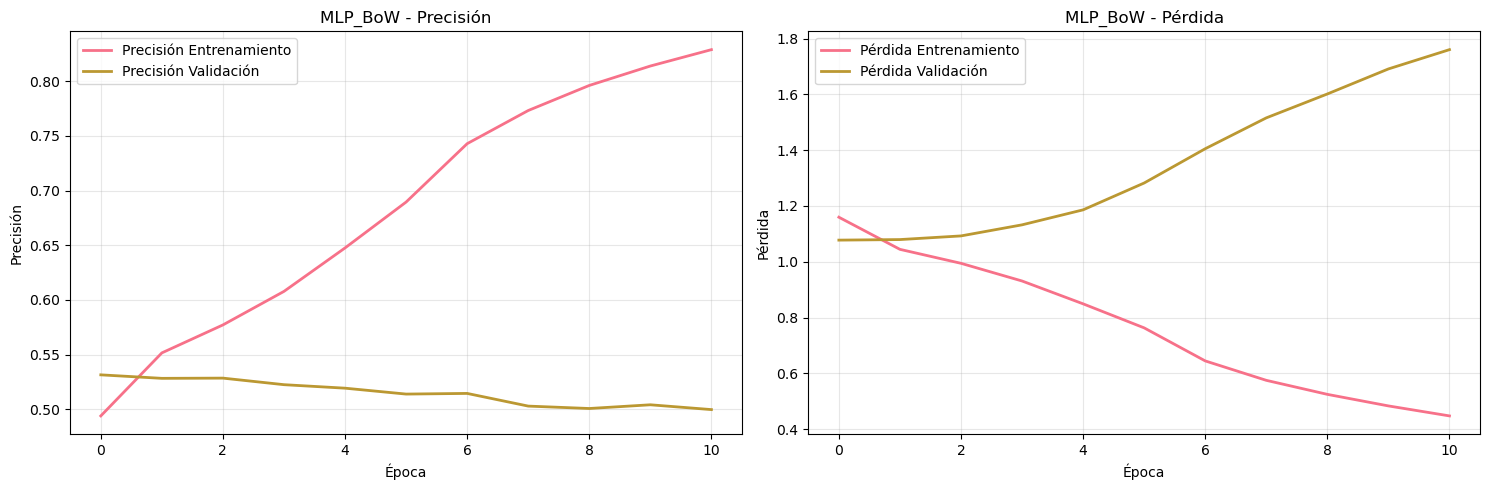

In [7]:
# Visualizar el historial de entrenamiento
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training_history.png")
)

## 7. Evaluación del Modelo

In [8]:
# Evaluar el modelo en el conjunto de prueba
evaluation_results = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    class_names=class_names
)

# Extraer métricas de evaluación
test_accuracy = evaluation_results['test_accuracy']
test_loss = evaluation_results['test_loss']
classification_rep = evaluation_results['classification_report']
y_true = evaluation_results['y_true']
y_pred = evaluation_results['y_pred']

print(f"\nResultados en conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...


2025-09-29 00:55:59.621922: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:55:59.621945: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 00:55:59.872557: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 4 bytes spill stores, 4 bytes spill loads

2025-09-29 00:56:00.223106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

 87/157 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step

2025-09-29 00:56:02.026133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 8 bytes spill stores, 8 bytes spill loads



157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Precisión de Prueba: 0.5290
Pérdida de Prueba: 1.0796

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.64      0.72      0.68      1000
           2       0.44      0.44      0.44      1000
           3       0.41      0.36      0.38      1000
           4       0.47      0.39      0.43      1000
           5       0.61      0.74      0.67      1000

    accuracy                           0.53      5000
   macro avg       0.52      0.53      0.52      5000
weighted avg       0.52      0.53      0.52      5000


Resultados en conjunto de prueba:
Accuracy: 0.5290
Loss: 1.0796
F1-Score (macro): 0.5205
F1-Score (weighted): 0.5205


## 8. Matriz de Confusión

Matriz de confusión guardada en: output/MLP_BoW_confusion_matrix.png


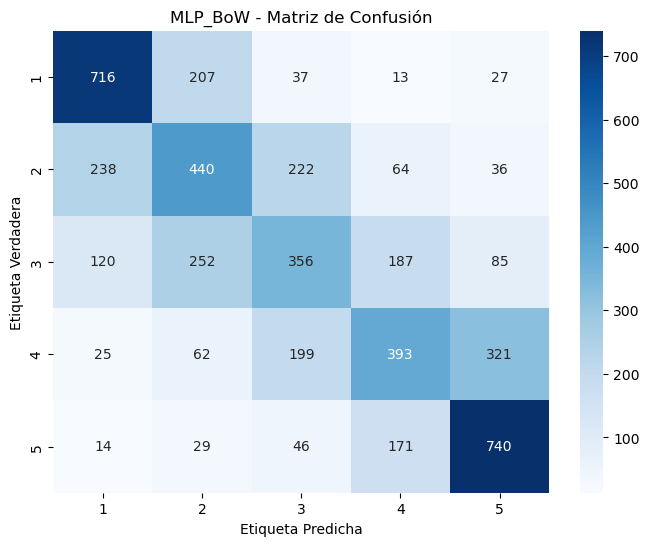

In [9]:
# Visualizar matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion_matrix.png")
)

## 9. Guardado de Resultados del Experimento

In [10]:
# Preparar datos del experimento para guardar
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'text_column': TEXT_COLUMN,
        'target_column': TARGET_COLUMN,
        'language_filter': FILTER_LANGUAGE,
        'max_features': MAX_FEATURES,
        'min_df': MIN_DF,
        'max_df': MAX_DF,
        'hidden_layers': HIDDEN_LAYERS,
        'activation': ACTIVATION,
        'output_activation': OUTPUT_ACTIVATION,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'patience': PATIENCE,
        'optimizer': OPTIMIZER,
        'loss_function': LOSS_FUNCTION,
        'random_seed': RANDOM_SEED,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict(),
        'language_used': FILTER_LANGUAGE if FILTER_LANGUAGE else "multilingual"
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'precision_macro': classification_rep['macro avg']['precision'],
        'recall_macro': classification_rep['macro avg']['recall'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar resultados del experimento
results_manager = ResultsManager(output_dir=OUTPUT_DIR)
experiment_id = results_manager.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado exitosamente.")
print(f"Idioma utilizado: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Modelo guardado en: {training_results['model_path']}")
print(f"Resultados guardados en: {OUTPUT_DIR}/experiment_history.json")

Experiment 2 results saved to output/experiment_history.json

Experimento #2 guardado exitosamente.
Idioma utilizado: en
Modelo guardado en: models/MLP_BoW_20250929_005527.h5
Resultados guardados en: output/experiment_history.json


## 10. Resumen del Experimento

In [11]:
# Mostrar resumen del experimento actual
print(f"RESUMEN DEL EXPERIMENTO #{experiment_id}")
print("=" * 60)
print(f"Modelo: {MODEL_TYPE}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma (todos)'}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print(f"Parámetros totales: {total_params:,}")
print(f"")
print(f"Dataset:")
print(f"  - Entrenamiento: {len(train_df):,} muestras")
print(f"  - Validación: {len(val_df):,} muestras")
print(f"  - Prueba: {len(test_df):,} muestras")
print(f"")
print(f"Entrenamiento:")
print(f"  - Épocas: {training_results['epochs_trained']}/{EPOCHS}")
print(f"  - Tiempo: {training_results['training_time']:.1f}s")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"")
print(f"Resultados:")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"  - F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")
print(f"")
print(f"Hardware: {'GPU' if gpu_info['gpu_available'] else 'CPU'}")

# Mostrar distribución de clases final
print(f"")
print(f"Distribución de clases utilizadas:")
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars} estrella(s): {count:,} ({percentage:.1f}%)")

RESUMEN DEL EXPERIMENTO #2
Modelo: MLP_BoW
Idioma: en
Arquitectura: [256, 128, 64]
Parámetros totales: 1,321,733

Dataset:
  - Entrenamiento: 200,000 muestras
  - Validación: 5,000 muestras
  - Prueba: 5,000 muestras

Entrenamiento:
  - Épocas: 11/50
  - Tiempo: 31.2s
  - Batch size: 512
  - Learning rate: 0.001

Resultados:
  - Test Accuracy: 0.5290
  - Test Loss: 1.0796
  - F1-Score (macro): 0.5205
  - F1-Score (weighted): 0.5205

Hardware: GPU

Distribución de clases utilizadas:
  1 estrella(s): 40,000 (20.0%)
  2 estrella(s): 40,000 (20.0%)
  3 estrella(s): 40,000 (20.0%)
  4 estrella(s): 40,000 (20.0%)
  5 estrella(s): 40,000 (20.0%)


## 11. Historial de Experimentos

In [12]:
# Mostrar historial completo de experimentos
results_manager.display_experiment_history()


HISTORIAL DE EXPERIMENTOS (2 experimentos)

ID  Modelo       Lang   Precisión  Pérdida    Épocas   Tiempo (s) Muestras  
-----------------------------------------------------------------------------------------------
1   MLP Embeddi  en     0.5932     0.9655     25       213.2      200,000   
2   MLP_BoW      en     0.4996     1.7601     11       31.2       200,000   

BEST EXPERIMENTS BY LANGUAGE:
--------------------------------------------------
en    : ID #1 - Accuracy: 0.5932 (200,000 samples)

OVERALL BEST: ID #1 (en) - Accuracy: 0.5932


## 12. Análisis de Errores

In [13]:
# Analizar algunos errores del modelo
def analyze_errors(X_test, y_test, y_pred, test_df, text_column, target_column, n_examples=5):
    """
    Analizar ejemplos donde el modelo se equivocó.
    """
    # Encontrar índices donde el modelo se equivocó
    y_test_labels = np.argmax(y_test, axis=1)
    error_indices = np.where(y_test_labels != y_pred)[0]
    
    if len(error_indices) == 0:
        print("Perfecto. El modelo no cometió errores en el conjunto de prueba.")
        return
    
    print(f"ANÁLISIS DE ERRORES ({len(error_indices)} errores total)")
    print("=" * 60)
    
    # Mostrar algunos ejemplos de errores
    sample_errors = np.random.choice(error_indices, 
                                   min(n_examples, len(error_indices)), 
                                   replace=False)
    
    for i, idx in enumerate(sample_errors):
        true_label = y_test_labels[idx]
        pred_label = y_pred[idx]
        
        # Construir el texto como se hizo en el preprocesamiento
        if USE_TITLE_AND_BODY and TITLE_COLUMN in test_df.columns:
            title = test_df.iloc[idx][TITLE_COLUMN]
            body = test_df.iloc[idx][text_column]
            text = f"{title} {body}"
        else:
            text = test_df.iloc[idx][text_column]
        
        print(f"Error #{i+1}:")
        print(f"Texto: {text[:150]}...")
        print(f"Etiqueta real: {true_label + 1} estrellas")
        print(f"Predicción: {pred_label + 1} estrellas")
        print("-" * 40)

# Realizar análisis de errores
analyze_errors(X_test, y_test, y_pred, test_df, TEXT_COLUMN, TARGET_COLUMN)

ANÁLISIS DE ERRORES (2355 errores total)
Error #1:
Texto: Four Stars I wear a 10.5 and they fit perfect...
Etiqueta real: 4 estrellas
Predicción: 5 estrellas
----------------------------------------
Error #2:
Texto: Cards are ok, but packaging is wasteful and expensive! Cards are ok — as pictured. But the packaging is wasteful and unnecessary. I’m sure a huge perc...
Etiqueta real: 2 estrellas
Predicción: 3 estrellas
----------------------------------------
Error #3:
Texto: The first bandage I pulled out was already open It was open and the bandage inside was quite crooked. Skeeved me out. The rest seemed to be sealed, bu...
Etiqueta real: 2 estrellas
Predicción: 1 estrellas
----------------------------------------
Error #4:
Texto: Perfect It fits as a true medium...
Etiqueta real: 4 estrellas
Predicción: 5 estrellas
----------------------------------------
Error #5:
Texto: Useless pockets! 😡 The pockets are so small I couldn't fit my phone in them. Aside from that's it's a nice fall t

## 13. Predicciones de Ejemplo

In [14]:
def predict_sample_texts(model, vectorizer, sample_texts, class_names):
    """
    Hacer predicciones en textos de ejemplo usando BoW/TF-IDF.
    
    Args:
        model: Modelo entrenado
        vectorizer: Vectorizador TF-IDF usado para entrenar
        sample_texts: Lista de textos de ejemplo
        class_names: Nombres de las clases
    """
    try:
        # Procesar textos con el vectorizador
        X_sample = vectorizer.transform(sample_texts)
        print(f"Shape de X_sample: {X_sample.shape}")
        
        # Convertir a array denso si es necesario
        if hasattr(X_sample, 'toarray'):
            X_sample_dense = X_sample.toarray()
        else:
            X_sample_dense = X_sample
        
        print(f"Shape después de conversión: {X_sample_dense.shape}")
        
        # Hacer predicciones
        predictions = model.predict(X_sample_dense, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        print("PREDICCIONES DE EJEMPLO (BoW/TF-IDF):")
        print("=" * 60)
        
        for i, text in enumerate(sample_texts):
            pred_class = predicted_classes[i]
            confidence = predictions[i][pred_class]
            
            print(f"Texto: {text[:100]}...")
            print(f"Predicción: {class_names[pred_class]} estrellas (confianza: {confidence:.3f})")
            print("-" * 40)
            
    except Exception as e:
        print(f"Error en predicción: {e}")
        print(f"Tipo de error: {type(e)}")
        # Información adicional para debug
        print(f"Shape del modelo entrada esperada: {model.input_shape}")
        print(f"Tipo de vectorizer: {type(vectorizer)}")

# Ejemplos de textos para probar - OPTIMIZADOS PARA BOW/TF-IDF
if USE_TITLE_AND_BODY:
    sample_texts = [
        "Excelente producto Este producto es excelente, muy buena calidad y llegó rápido. Recomendado totalmente.",
        "Producto terrible Terrible producto, no funciona como se describe. Muy decepcionante.", 
        "Producto normal El producto está bien, cumple con lo básico. Nada extraordinario.",
        "Producto increíble Increíble calidad, superó mis expectativas completamente. Cinco estrellas.",
        "No recomendado No recomiendo este producto, muy mala experiencia de compra. Una estrella."
    ]
    print("Usando formato: [TÍTULO] + [CUERPO] procesado con BoW/TF-IDF")
else:
    sample_texts = [
        "Este producto es excelente, muy buena calidad y llegó rápido. Recomendado totalmente.",
        "Terrible producto, no funciona como se describe. Muy decepcionante.", 
        "El producto está bien, cumple con lo básico. Nada extraordinario.",
        "Increíble calidad, superó mis expectativas completamente. Cinco estrellas.",
        "No recomiendo este producto, muy mala experiencia de compra. Una estrella."
    ]
    print("Usando formato: solo [CUERPO] procesado con BoW/TF-IDF")

print(f"Vocabulario del modelo: {vocab_size:,} características")

# Hacer predicciones en ejemplos
predict_sample_texts(
    model=model,
    vectorizer=data_loader.vectorizer,
    sample_texts=sample_texts,
    class_names=class_names
)

Usando formato: [TÍTULO] + [CUERPO] procesado con BoW/TF-IDF
Vocabulario del modelo: 5,000 características
Shape de X_sample: (5, 5000)
Shape después de conversión: (5, 5000)


2025-09-29 00:56:04.594352: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 8 bytes spill stores, 8 bytes spill loads



PREDICCIONES DE EJEMPLO (BoW/TF-IDF):
Texto: Excelente producto Este producto es excelente, muy buena calidad y llegó rápido. Recomendado totalme...
Predicción: 2 estrellas (confianza: 0.319)
----------------------------------------
Texto: Producto terrible Terrible producto, no funciona como se describe. Muy decepcionante....
Predicción: 1 estrellas (confianza: 0.928)
----------------------------------------
Texto: Producto normal El producto está bien, cumple con lo básico. Nada extraordinario....
Predicción: 2 estrellas (confianza: 0.374)
----------------------------------------
Texto: Producto increíble Increíble calidad, superó mis expectativas completamente. Cinco estrellas....
Predicción: 2 estrellas (confianza: 0.319)
----------------------------------------
Texto: No recomendado No recomiendo este producto, muy mala experiencia de compra. Una estrella....
Predicción: 2 estrellas (confianza: 0.319)
----------------------------------------
